# The <code class="side-menu-class-name">RunnerSymmetryFunctionValues</code> class

_Run this notebook directly in your browser through Binder:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/runner-suite%2Frunnerase-usage-environment/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgitlab.com%252Frunner-suite%252Frunnerase-usage%26urlpath%3Dtree%252Frunnerase-usage%252Fstorage_sfvalues.ipynb%26branch%3Dmain)_

In [55]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

from runnerase.calculators.runner import Runner
from ase.io import read
from runnerase import generate_symmetryfunctions

`RunnerSymmetryFunctionValues` is a storageclass for calculation results that are typically generated during Mode 1. It stores the values of all symmetry functions for each atom in the dataset.

Let us run a quick mode 1 calculation to have some results to inspect:

In [99]:
RUNNER_CMD = 'RuNNer.serial.x > PREFIX.out'

calc = Runner(
    command=RUNNER_CMD,
    dataset=read('data/input.data', index=':', format='runnerdata'),
    label='mode1/mode1'
)

# Reset the symmetry function container. 
calc.symmetryfunctions.reset()

# Generate radial symmetry functions.
radials = generate_symmetryfunctions(calc.dataset, sftype=2, amount=6,
                                     algorithm='shifted', cutoff=4.0)
calc.symmetryfunctions += radials

# Generate angular symmetry functions.
angulars = generate_symmetryfunctions(calc.dataset, sftype=3, amount=4,
                                      algorithm='literature', cutoff=8.0)
calc.symmetryfunctions += angulars

calc.run(mode=1)

Mode 1: No. Structures:   0%|          | 0/100 [00:00<?, ?it/s]

Mode 1: No. Structures: 100%|██████████| 100/100 [00:00<00:00, 279.46it/s]


As you can, `calc.results` now contains a `sfvalues` key:

In [100]:
calc.results

{'sfvalues': RunnerSymmetryFunctionValues(n_structures=100),
 'splittraintest': RunnerSplitTrainTest(n_train=88, n_test=12)}

## Class Properties

The class stores a list of `RunnerStructureSymmetryFunctionValues` objects (yes, the name is long), one for each structure in the dataset.

In [101]:
sfvalues = calc.results['sfvalues']
len(sfvalues)

100

You can access the symmetry function values for a single structure by indexing `sfvalues` itself:

In [102]:
sfvalues[0]

RunnerStructureSymmetryFunctionValues(n_atoms=48)

`RunnerStructureSymmetryFunctionValues` holds a dictionary: each key (= element symbol) contains a numpy array with the symmetry function values of all atoms belonging to that element within the structure. For example

In [103]:
sfvalues[0]['H'].shape

(32, 37)

In the structure there are 32 hydrogen atoms (from 16 water molecules). Each of them has 60 symmetry functions. The first index of the array that is stored is the index of that atom in the original structure. That way we can recompose the symmetry function values in the correct order, for example for iterating:

In [104]:
sfvalues_for_each_atom = sfvalues[0].by_atoms()
sfvalues_for_each_atom[0]

('O',
 array([1.09193203e+00, 1.00854636e+00, 7.66010129e-01, 4.93255410e-01,
        2.83417679e-01, 1.53958043e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.75221230e+00, 5.42455748e-01, 2.90150084e-02, 3.25048751e+00,
        2.60640086e+00, 6.97890322e-02, 1.65632580e+00, 2.41661258e-01,
        9.11391380e-03, 2.15460100e+00, 2.30560637e+00, 4.98879375e-02,
        8.54222052e-01, 9.25401483e-02, 1.08903730e-03, 1.23629148e+00,
        1.96706500e+00, 2.62861345e-02, 4.52075648e-01, 4.12431681e-02,
        2.66280000e-05, 6.65510410e-01, 1.64774093e+00, 7.99987540e-03]))

The `by_atoms` function creates a list of tuples, one for each atom in the structure. The tuples consists of the element and the symmetry function values of that atom.

## Writing symmetry function values

The `write` routine of `RunnerSymmetryFunctionValues` takes a file and indices as its arguments. This way, we can write only a selection of all structures in storage to the file. Here we use that feature to write only the train set symmetry functions:

In [105]:
sfvalues.write('sfvalues.out', index=calc.splittraintest.train)

## Plotting

The class comes with a `plot` interface which returns a `RunnenSymmetryFunctionValuesPlots` object. It offers multiple ways to analyse the symmetry function values of your dataset.

## Boxplot

The boxplot allows you assess the symmetry function ranges in a graphical way:

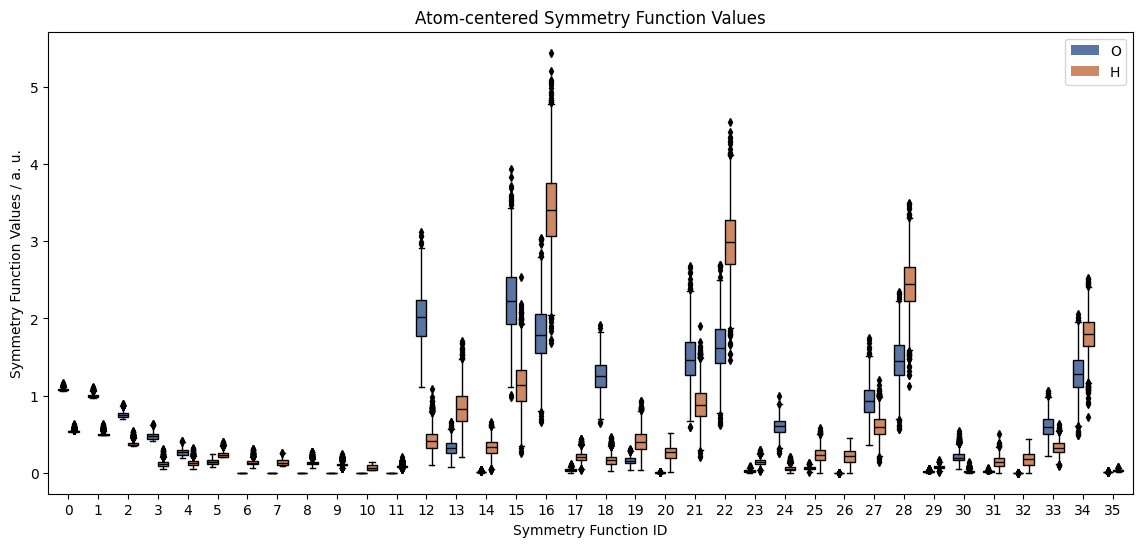

In [106]:
fig, ax = plt.subplots(figsize=(14, 6))
sfvalues.plot.boxplot()
plt.show()

## Dimensionality Reduction

The class offers a very generic interface to sklearn library for data analysis. Pass any `method` argument to the `sfvalues.sklearn_dimensionality_reduction` procedure that has a `fit_transform` property.

Moreover, the class implements two shortcuts, `pca` and `tsne`, for the two popular algorithms.

Processing element O...
Processing element H...


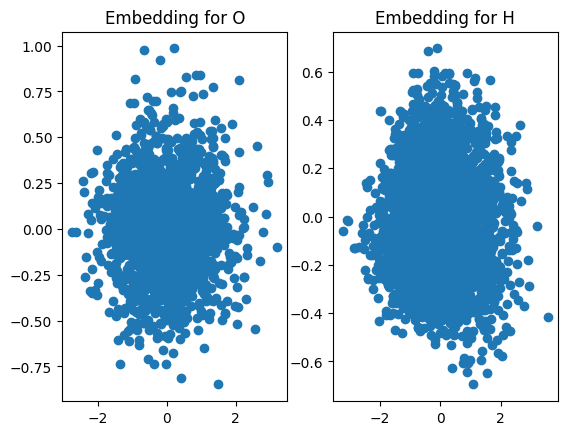

In [107]:
sfvalues.plot.pca()
plt.show()

Processing element O...
Processing element H...


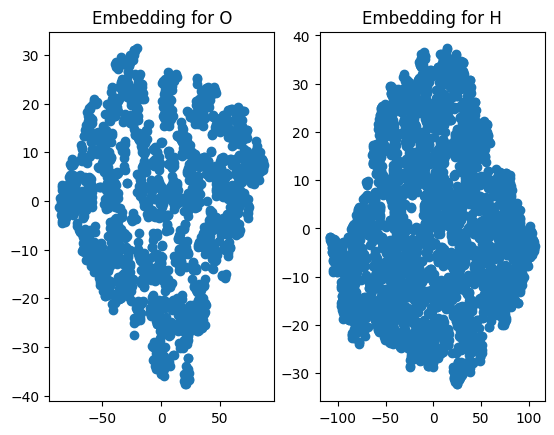

In [108]:
sfvalues.plot.tsne()
plt.show()

All of these methods also accept a `label` argument for coloring. This a dictionary containing a list of float values for each element in the dataset. For example, we can color the points by their maximum force:

In [109]:
tsne_labels = defaultdict(list)

for idx_struc, structure in enumerate(sfvalues):
    structure_calculator = calc.dataset[idx_struc].calc

    for idx_atom, (element, _) in enumerate(structure.by_atoms()):
        forces = structure_calculator.results['forces']
        max_forces = max(forces[idx_atom, :])

        tsne_labels[element].append(max_forces)

Processing element O...
Processing element H...


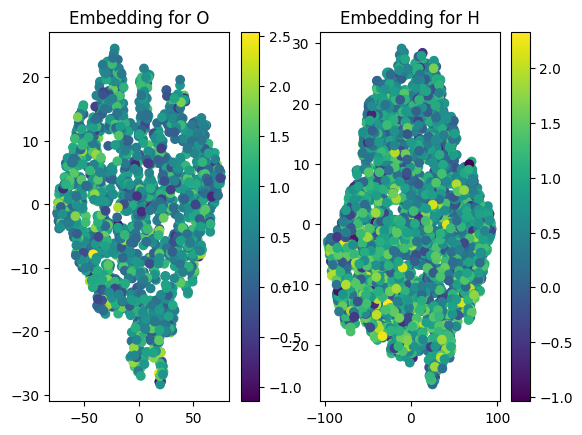

In [110]:
sfvalues.plot.tsne(
    n_components=2,
    perplexity=30.0,
    labels=tsne_labels
)
plt.show()